In [1]:
import nltk
print('The nltk version is {}.'.format(nltk.__version__))

The nltk version is 3.8.1.


In [2]:
!pip install tensorflow==2.15.1
import pathlib
import random
import string
import re
import os
import time
import tensorflow as tf
import numpy as np
import unicodedata
from collections import Counter
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from google.colab import drive
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [3]:
# File paths
Amharic = "/content/drive/My Drive/ElasticNet/Amharic.txt"
English = "/content/drive/My Drive/ElasticNet/English.txt"

# Read the files
try:
    with open(Amharic, 'r', encoding='utf-8') as am_file, open(English, 'r', encoding='utf-8') as en_file:
        amharic_sentences = am_file.read().splitlines()
        english_sentences = en_file.read().splitlines()
except FileNotFoundError as e:
    print(f"File not found: {e}")
    raise

def remove_special_chars(text):
    return re.sub(r'[^a-zA-Z0-9\s.,;:!?\'"()\[\]{}\\/-]', '', text) #remove any character that is not a letter, digit, whitespace, punctuation, bracket, or slash

def handle_unicode(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

def expand_contractions(text):
    contractions = {
        "n't": " not",
        "'s": [" is", " was"],  # Can be either "is" or "was"
        "'m": " am",
        "'re": " are",
        "'ll": " will",
        "'ve": " have",
        "'d": [" would", " had"]  # Can be either "would" or "had"
    }
    for contraction, expansion in contractions.items():
        if isinstance(expansion, list):
            for exp in expansion:
                text = text.replace(contraction, exp)
        else:
            text = text.replace(contraction, expansion)
    return text

def remove_excess_whitespace(text):
    return ' '.join(text.split())

# Preprocess Amharic sentences
def preprocess_amharic(text):
    # Remove any non-Amharic characters (keeping spaces, Amharic/Arabic numbers, and Amharic punctuation)
    text = re.sub(r'[^\u1200-\u137F\u1361-\u1368\u1369-\u1371\u0030-\u0039\s\[\]{}\\/-]', '', text)
     # \u1200-\u137F matches Amharic characters/Scripts.
     # \u1361-\u1368 matches Amharic punctuation marks.
     # \u1369-\u1371 matches Amharic numbers.
     # \u0030-\u0039 matches Arabic digits.
     # Remove excess whitespac

    # Remove excess whitespace
    text = remove_excess_whitespace(text)
    return list(text)  # Return a list of characters

# Preprocess English sentences
def preprocess_english(text):
    text = handle_unicode(text)
    text = expand_contractions(text)
    text = remove_special_chars(text)
    text = remove_excess_whitespace(text)
    return list(text)  # Return a list of characters

In [4]:
# Preprocess sentences and calculate lengths
am_lengths = []
en_lengths = []
text_pairs = []
for am_sentence, en_sentence in zip(amharic_sentences, english_sentences):
    am_processed = preprocess_amharic(am_sentence)
    en_processed = preprocess_english(en_sentence)
    am_length = len(am_processed)  # list of Amharic characters
    en_length = len(en_processed)  # list of English characters

    # Filter out zero-length sentences
    if am_length > 0 and en_length > 0:
        am_lengths.append(am_length)
        en_lengths.append(en_length)
        text_pairs.append((''.join(am_processed), ''.join(en_processed)))  # Join characters back into a string
# Calculate min and max lengths for each language
am_min_length = min(am_lengths)
am_max_length = max(am_lengths)
en_min_length = min(en_lengths)
en_max_length = max(en_lengths)

# Calculate overall min and max lengths
min_length = min(am_min_length, en_min_length)
max_length = max(am_max_length, en_max_length)

print(f"Amharic minimum sentence length: {am_min_length}")
print(f"Amharic maximum sentence length: {am_max_length}")
print(f"English minimum sentence length: {en_min_length}")
print(f"English maximum sentence length: {en_max_length}")
print(f"Overall minimum sentence length: {min_length}")
print(f"Overall maximum sentence length: {max_length}")

# Filter sentences based on length
filtered_pairs = []
filtered_am_lengths = []
filtered_en_lengths = []

for (am_sentence, en_sentence), am_length, en_length in zip(text_pairs, am_lengths, en_lengths):
    if min_length <= am_length <= max_length and min_length <= en_length <= max_length:
        am_sentence = "[start] " + am_sentence + " [end]"
        en_sentence = "[start] " + en_sentence + " [end]"
        filtered_pairs.append((am_sentence, en_sentence))
        filtered_am_lengths.append(am_length)
        filtered_en_lengths.append(en_length)

# Print the number of pairs before and after filtering
print(f"Number of pairs before filtering: {len(text_pairs)}")
print(f"Number of pairs after filtering: {len(filtered_pairs)}")

# Calculate combined lengths and handle single occurrences
combined_lengths = [am + en for am, en in zip(filtered_am_lengths, filtered_en_lengths)]
counts = Counter(combined_lengths)
# Filter out lengths that occur only once
filtered_pairs = [pair for pair, length in zip(filtered_pairs, combined_lengths) if counts[length] > 1]
filtered_lengths = [length for length in combined_lengths if counts[length] > 1]

# Split the data into train, validation, and test sets with stratification
train_pairs, test_pairs = train_test_split(filtered_pairs, test_size=0.2, random_state=42, stratify=filtered_lengths)
train_lengths, test_lengths = train_test_split(filtered_lengths, test_size=0.2, random_state=42, stratify=filtered_lengths)

train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42, stratify=train_lengths)
train_lengths, val_lengths = train_test_split(train_lengths, test_size=0.2, random_state=42, stratify=train_lengths)

# Print the size of each set
print(f"{len(filtered_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

Amharic minimum sentence length: 1
Amharic maximum sentence length: 892
English minimum sentence length: 1
English maximum sentence length: 1323
Overall minimum sentence length: 1
Overall maximum sentence length: 1323
Number of pairs before filtering: 100481
Number of pairs after filtering: 100481
100345 total pairs
64220 training pairs
16056 validation pairs
20069 test pairs


In [5]:
# Custom standardization function
def custom_standardization(input_string):
    return tf.strings.lower(input_string)

# Tokenize and count frequency
def tokenize_and_count(texts):
    all_tokens = []
    for text in texts:
        tokens = text.split()
        all_tokens.extend(tokens)
    return Counter(all_tokens)

train_am_texts = [pair[0] for pair in train_pairs]
train_en_texts = [pair[1] for pair in train_pairs]

am_token_freq = tokenize_and_count(train_am_texts)
en_token_freq = tokenize_and_count(train_en_texts)

# Calculate and print max tokens for both languages
am_max_tokens = max(len(text.split()) for text in train_am_texts)
en_max_tokens = max(len(text.split()) for text in train_en_texts)

print(f"Max tokens in Amharic: {am_max_tokens}")
print(f"Max tokens in English: {en_max_tokens}")

# Calculate the 95th percentile of token counts
am_token_counts = [len(text.split()) for text in train_am_texts]
en_token_counts = [len(text.split()) for text in train_en_texts]
am_95th_percentile = int(np.percentile(am_token_counts, 95))
en_95th_percentile = int(np.percentile(en_token_counts, 95))
print(f"95th percentile of token counts in Amharic: {am_95th_percentile}")
print(f"95th percentile of token counts in English: {en_95th_percentile}")

Max tokens in Amharic: 105
Max tokens in English: 141
95th percentile of token counts in Amharic: 31
95th percentile of token counts in English: 46


In [6]:
def get_max_sequence_length(texts):
    return max([len(text) for text in texts])

# Preprocess and get max lengths
am_texts = [' '.join(preprocess_amharic(text)) for text, _ in train_pairs + val_pairs + test_pairs]
en_texts = [' '.join(preprocess_english(text)) for _, text in train_pairs + val_pairs + test_pairs]

max_am_sequence_length = get_max_sequence_length(am_texts)
max_en_sequence_length = get_max_sequence_length(en_texts)

print(f"Max Amharic sequence length: {max_am_sequence_length}")
print(f"Max English sequence length: {max_en_sequence_length}")

# TextVectorization layers with max sequence lengths
am_vectorization = layers.TextVectorization(
    max_tokens=None,
    output_mode="int",
    output_sequence_length=max_am_sequence_length,
    standardize=custom_standardization,
    split='character'
)
en_vectorization = layers.TextVectorization(
    max_tokens=None,
    output_mode="int",
    output_sequence_length=max_en_sequence_length,
    standardize=custom_standardization,
    split='character'
)

# Adapt vectorization layers on training data
am_vectorization.adapt(train_am_texts)
en_vectorization.adapt(train_en_texts)

# Vocabulary sizes
amharic_vocab_size = len(am_vectorization.get_vocabulary())
english_vocab_size = len(en_vectorization.get_vocabulary())
print(f"Amharic vocabulary size: {amharic_vocab_size}")
print(f"English vocabulary size: {english_vocab_size}")

Max Amharic sequence length: 1053
Max English sequence length: 1733
Amharic vocabulary size: 318
English vocabulary size: 55


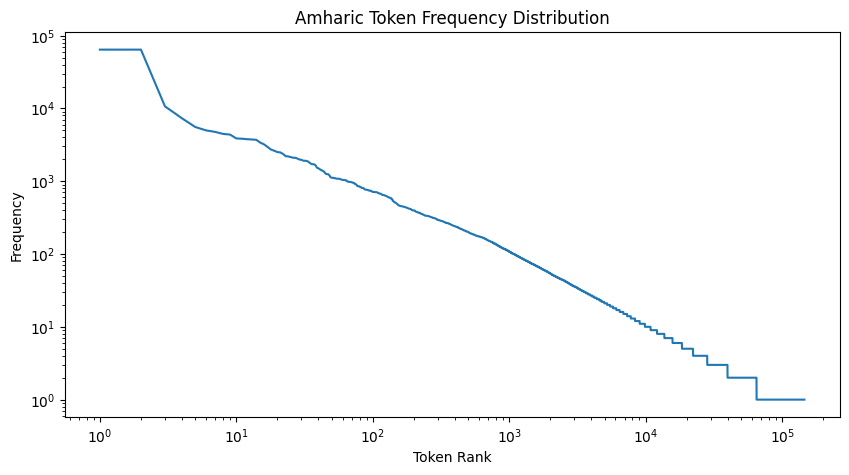

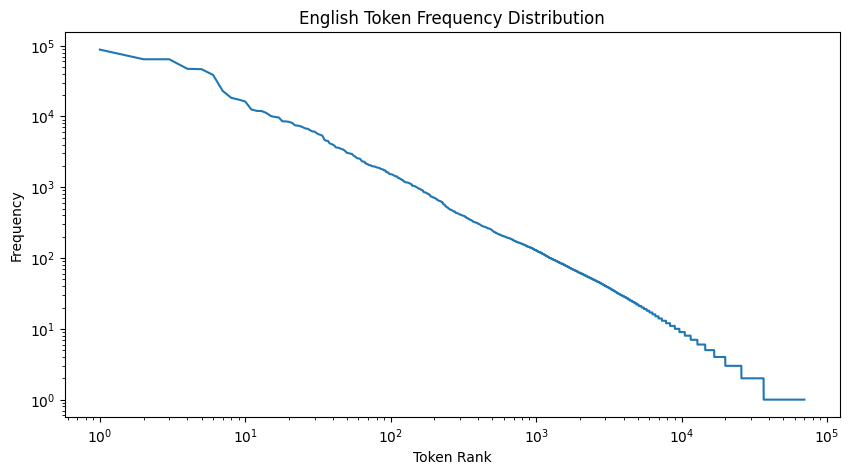

In [7]:
def plot_token_frequency(token_freq, language):
    freq = sorted(token_freq.values(), reverse=True)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(freq) + 1), freq)
    plt.title(f'{language} Token Frequency Distribution')
    plt.xlabel('Token Rank')
    plt.ylabel('Frequency')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

plot_token_frequency(am_token_freq, 'Amharic')
plot_token_frequency(en_token_freq, 'English')

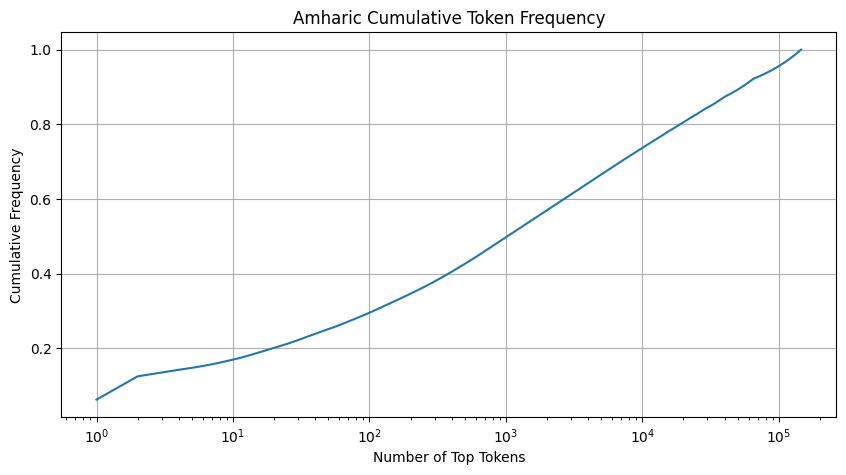

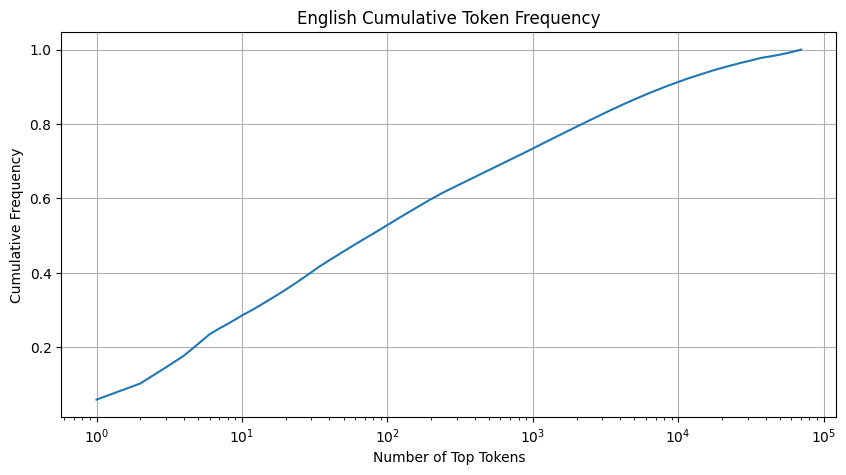

In [8]:
# Plot cumulative frequency distribution
def plot_cumulative_frequency(token_freq, language):
    freq = sorted(token_freq.values(), reverse=True)
    total = sum(freq)
    cumulative = np.cumsum(freq) / total
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative) + 1), cumulative)
    plt.title(f'{language} Cumulative Token Frequency')
    plt.xlabel('Number of Top Tokens')
    plt.ylabel('Cumulative Frequency')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

plot_cumulative_frequency(am_token_freq, 'Amharic')
plot_cumulative_frequency(en_token_freq, 'English')

In [9]:
# Parameters
batch_size = 64
d_model = 256
latent_dim = 524
num_heads = 8
num_layers = 5
dropout_rate = 0.3

# Dataset formatting function
def format_dataset(am, en):
    am = am_vectorization(am)
    en = en_vectorization(en)
    return ({"encoder_inputs": am, "decoder_inputs": en[:, :-1]}, en[:, 1:])

def make_dataset(pairs, batch_size):
    am_texts, en_texts = zip(*pairs)
    am_texts = [' '.join(preprocess_amharic(text)) for text in am_texts]
    en_texts = [' '.join(preprocess_english(text)) for text in en_texts]
    dataset = tf.data.Dataset.from_tensor_slices((am_texts, en_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset.shuffle(1024).prefetch(tf.data.experimental.AUTOTUNE).cache()

# Create the datasets
train_ds = make_dataset(train_pairs, batch_size)
val_ds = make_dataset(val_pairs, batch_size)
test_ds = make_dataset(test_pairs, batch_size)

In [10]:
# Define Elastic Net regularization
elastic_net = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)

# Scaled Dot-Product Attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-Head Attention
class CustomMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(CustomMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(0.3) 
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        original_q = tf.reshape(tf.transpose(q, perm=[0, 2, 1, 3]), (batch_size, -1, self.d_model))
        output = self.layernorm(output + original_q)

        return output, attention_weights


# Point-Wise Feed Forward Network with dropout, elastic net regularizer and layer normalization
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=elastic_net),
        tf.keras.layers.Dense(d_model, kernel_regularizer=elastic_net),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LayerNormalization(epsilon=1e-6)
    ])


def get_angles(pos, i, d_model):
    angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return tf.cast(pos, tf.float32) * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model
    )

    # Apply sin to even indices in the array; 2i
    sines = tf.math.sin(angle_rads[:, 0::2])

    # Apply cos to odd indices in the array; 2i+1
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    return tf.cast(pos_encoding, tf.float32)

# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.3):
        super(EncoderLayer, self).__init__()
        self.mha = CustomMultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.3):
        super(DecoderLayer, self).__init__()
        self.mha1 = CustomMultiHeadAttention(d_model, num_heads)
        self.mha2 = CustomMultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)
        return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, amharic_vocab_size, rate=0.3):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(amharic_vocab_size, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += positional_encoding(seq_len, self.d_model)
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, english_vocab_size, rate=0.3):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(english_vocab_size, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += positional_encoding(seq_len, self.d_model)
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        return x, attention_weights

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, amharic_vocab_size, english_vocab_size, rate=0.3):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, amharic_vocab_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, english_vocab_size, rate)
        self.final_layer = tf.keras.layers.Dense(english_vocab_size)

        # Store the parameters for serialization
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.amharic_vocab_size = amharic_vocab_size
        self.english_vocab_size = english_vocab_size
        self.dropout_rate = rate

    def call(self, inputs, training=False):
        if isinstance(inputs, dict):
            inp, tar = inputs['encoder_inputs'], inputs['decoder_inputs']
        else:
            inp, tar = inputs

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar)

        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, combined_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions, _ = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        inputs, targets = data
        predictions, _ = self(inputs, training=False)
        self.compiled_loss(targets, predictions, regularization_losses=self.losses)
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

    def get_config(self):
        return {
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "amharic_vocab_size": self.amharic_vocab_size,
            "english_vocab_size": self.english_vocab_size,
            "rate": self.dropout_rate,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Custom learning rate schedule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(tf.cast(self.d_model, tf.float32)) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps
        }

# Function to create masks
def create_masks(inp, tar):
    enc_padding_mask = tf.cast(tf.math.equal(inp, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]
    dec_padding_mask = tf.cast(tf.math.equal(inp, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((tf.shape(tar)[1], tf.shape(tar)[1])), -1, 0)
    dec_target_padding_mask = tf.cast(tf.math.equal(tar, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

# Loss and Accuracy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

# Define a dictionary of custom objects
custom_objects = {
    'Transformer': Transformer,
    'CustomSchedule': CustomSchedule,
    'Encoder': Encoder,
    'Decoder': Decoder,
    'EncoderLayer': EncoderLayer,
    'DecoderLayer': DecoderLayer,
    'CustomMultiHeadAttention': CustomMultiHeadAttention
}
# Create Transformer instances
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=latent_dim,
    amharic_vocab_size=amharic_vocab_size,
    english_vocab_size=english_vocab_size,
    rate=dropout_rate
)

# Define the optimizer and loss function
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
transformer.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Assuming you have a batch of data (batch_encoder_inputs, batch_decoder_inputs)
batch_encoder_inputs = tf.random.uniform((batch_size, max_am_sequence_length), dtype=tf.int64, minval=0, maxval=amharic_vocab_size)
batch_decoder_inputs = tf.random.uniform((batch_size, max_en_sequence_length), dtype=tf.int64, minval=0, maxval=english_vocab_size)

# Pass the data through the model
_ = transformer({'encoder_inputs': batch_encoder_inputs, 'decoder_inputs': batch_decoder_inputs})

#call summary
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder (Trans  multiple                  2218544   
 formerEncoder)                                                  
                                                                 
 transformer_decoder (Trans  multiple                  3207984   
 formerDecoder)                                                  
                                                                 
 dense_64 (Dense)            multiple                  14135     
                                                                 
Total params: 5440663 (20.75 MB)
Trainable params: 5440663 (20.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define metrics for training and validation
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Checkpointing
checkpoint_path = "./checkpoints"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Custom training step with gradient clipping
@tf.function
def train_step(model, inputs, target):
    encoder_inputs = inputs["encoder_inputs"]
    decoder_inputs = inputs["decoder_inputs"]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_inputs, decoder_inputs)
    with tf.GradientTape() as tape:
        predictions, _ = model({"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs}, training=True)
        loss = loss_fn(target, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(target, predictions)

# Custom validation step
@tf.function
def val_step(model, inputs, target):
    encoder_inputs = inputs["encoder_inputs"]
    decoder_inputs = inputs["decoder_inputs"]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_inputs, decoder_inputs)
    predictions, _ = model({"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs}, training=False)
    loss = loss_fn(target, predictions)
    val_loss(loss)
    val_accuracy(target, predictions)

# Training and evaluation function with manual early stopping logic
def train_and_evaluate(model, train_ds, val_ds, epochs, patience=15):
    total_start_time = time.time()
    best_val_loss = float('inf')
    patience_counter = 0
    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        print(f"\nEpoch {epoch + 1}:")

        # Training
        for batch, (inputs, target) in enumerate(train_ds):
            train_step(model, inputs, target)
            if batch % 100 == 0:
                print(f"Batch {batch} Loss {train_loss.result()} Accuracy {train_accuracy.result()}")

        # Validation
        for batch, (inputs, target) in enumerate(val_ds):
            val_step(model, inputs, target)
            if batch % 100 == 0:
                print(f"Validation Batch {batch} Loss {val_loss.result()} Accuracy {val_accuracy.result()}")

        print(f"Epoch {epoch + 1}: Train Loss {train_loss.result()}, Train Accuracy {train_accuracy.result()}")
        print(f"Val Loss {val_loss.result()}, Val Accuracy {val_accuracy.result()}")
        print(f"Time taken for Epoch {epoch + 1}: {time.time() - start} secs\n")

        # Store metrics for plotting
        train_losses.append(train_loss.result().numpy())
        val_losses.append(val_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        val_accuracies.append(val_accuracy.result().numpy())

        # Check for improvement
        if val_loss.result() < best_val_loss:
            best_val_loss = val_loss.result()
            patience_counter = 0
            best_weights = model.get_weights()
            print("Best model saved with Val Loss:", best_val_loss)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {epoch + 1} epochs due to no improvement in validation loss.")
                break

    total_time_taken = time.time() - total_start_time

    # Restore best weights
    model.set_weights(best_weights)

    # Save the trained model
    save_dir = "/content/drive/My Drive/ElasticNet/SavedModel"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    with tf.keras.utils.custom_object_scope(custom_objects):
        model.save(os.path.join(save_dir, 'transformer_Baseline'))
    print("Final model saved to {save_dir}")

    # Calculate the total average Train and Validation loss and accuracy across all epochs
    total_avg_train_losses = np.mean(train_losses)
    total_avg_train_accuracies = np.mean(train_accuracies)
    total_avg_val_loss = np.mean(val_losses)
    total_avg_val_accuracy = np.mean(val_accuracies)

    print("\nTotal Average Results:")
    print(f"Total Average Train Accuracy: {total_avg_train_accuracies:.4f}")
    print(f"Total Average Train Loss: {total_avg_train_losses:.4f}")
    print(f"Total Average Validation Accuracy: {total_avg_val_accuracy:.4f}")
    print(f"Total Average Validation Loss: {total_avg_val_loss:.4f}")
    print(f"Total Time Taken for Training: {total_time_taken:.2f} seconds")

    return train_losses, val_losses, train_accuracies, val_accuracies, total_avg_train_losses, total_avg_train_accuracies, total_avg_val_loss, total_avg_val_accuracy, total_time_taken

# Training
train_losses, val_losses, train_accuracies, val_accuracies, total_avg_train_losses, total_avg_train_accuracies, total_avg_val_loss, total_avg_val_accuracy, total_time_taken = train_and_evaluate(transformer, train_ds, val_ds, epochs=20, patience=5)


Epoch 1:
Batch 0 Loss 10.712542533874512 Accuracy 0.0
Batch 100 Loss 10.305157661437988 Accuracy 0.34971439838409424
Batch 200 Loss 9.59660530090332 Accuracy 0.5183541178703308
Batch 300 Loss 8.713781356811523 Accuracy 0.5765005946159363
Batch 400 Loss 7.6883320808410645 Accuracy 0.605678141117096
Batch 500 Loss 6.728085041046143 Accuracy 0.623737633228302
Batch 600 Loss 5.996492862701416 Accuracy 0.6355808973312378
Batch 700 Loss 5.443461894989014 Accuracy 0.6469284892082214
Batch 800 Loss 5.03415584564209 Accuracy 0.6543002724647522
Batch 900 Loss 4.710638046264648 Accuracy 0.660430371761322
Batch 1000 Loss 4.44462776184082 Accuracy 0.665996789932251
Validation Batch 0 Loss 2.011645555496216 Accuracy 0.7288461327552795
Validation Batch 100 Loss 2.0952343940734863 Accuracy 0.7122952938079834
Validation Batch 200 Loss 2.0984256267547607 Accuracy 0.7125099897384644
Epoch 1: Train Loss 4.435446262359619, Train Accuracy 0.6661393046379089
Val Loss 2.098444700241089, Val Accuracy 0.712562

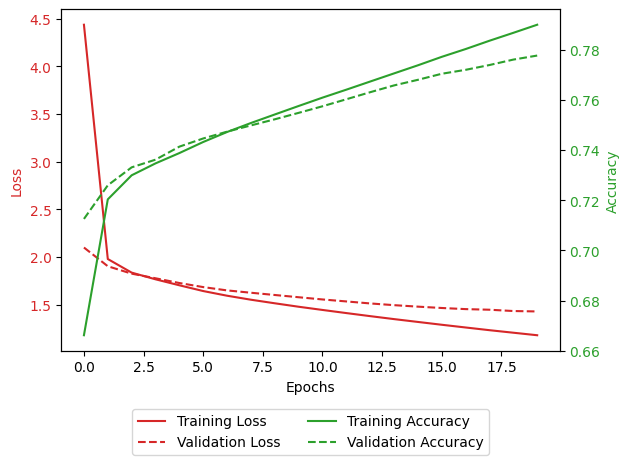

In [ ]:
# Plotting training and validation loss and accuracy
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    train_loss_line, = ax1.plot(range(epochs), train_losses, label='Training Loss', color=color)
    val_loss_line, = ax1.plot(range(epochs), val_losses, label='Validation Loss', linestyle='dashed', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Plotting training and validation accuracy
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color)
    train_acc_line, = ax2.plot(range(epochs), train_accuracies, label='Training Accuracy', color=color)
    val_acc_line, = ax2.plot(range(epochs), val_accuracies, label='Validation Accuracy', linestyle='dashed', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Adding the legend
    lines = [train_loss_line, val_loss_line, train_acc_line, val_acc_line]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    fig.tight_layout()
    plt.show()

# Plotting metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs=30)

In [ ]:
# Testing the model (Evaluate the model on the test dataset)
def test_model(model, test_ds, loss_fn, create_masks):
    test_loss = 0
    test_accuracy = 0
    num_batches = 0

    for (batch, (inputs, target)) in enumerate(test_ds):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inputs["encoder_inputs"], inputs["decoder_inputs"])

        # Pass all required arguments to the model
        predictions, _ = model({"encoder_inputs": inputs["encoder_inputs"],
                                "decoder_inputs": inputs["decoder_inputs"],
                                "enc_padding_mask": enc_padding_mask,
                                "look_ahead_mask": combined_mask,
                                "dec_padding_mask": dec_padding_mask},
                               training=False)  # 'training' argument is passed here
         # Calculate loss
        loss = loss_fn(target, predictions)
        test_loss += loss.numpy()

        # Calculate accuracy
        batch_accuracy = np.mean(np.argmax(predictions, axis=-1) == target.numpy())
        test_accuracy += batch_accuracy

        num_batches += 1

    test_loss /= num_batches
    test_accuracy /= num_batches

    print(f"Test loss: {test_loss}")
    print(f"Test accuracy: {test_accuracy}")

# Testing
test_model(transformer, test_ds, loss_fn, create_masks)

Test loss: 1.4121106620818848
Test accuracy: 0.779245777370777
